Import the required libraries

In [10]:
# import the libraries as shown below
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator,load_img

In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from glob import glob

In [5]:
import seaborn as sns

Loading the data for Visualize the train and test data analysis

In [7]:
labels = ['jute', 'maize','rice','sugarcane','wheat']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [11]:
#Now we can easily fetch our train and validation data.
train_path = get_data('/content/drive/MyDrive/Crop dataset/train')
test_path = get_data('/content/drive/MyDrive/Crop dataset/test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


Visualize the train data analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train data')

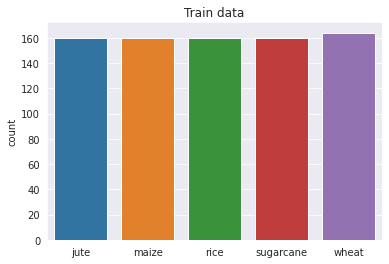

In [13]:
l = []
for i in train_path:
    if(i[1] == 0):
        l.append("jute")
    if(i[1] == 1):
        l.append("maize")
    if(i[1] == 2):
        l.append("rice")
    if(i[1] == 3):
        l.append("sugarcane")
    if(i[1] == 4):
        l.append("wheat")
sns.set_style('darkgrid')
sns.countplot(l).set_title('Train data')

Visualize the test data analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test data')

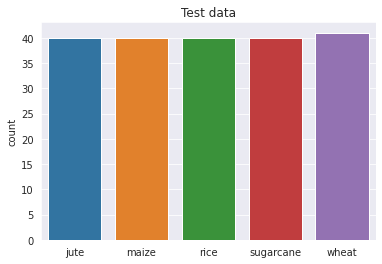

In [16]:
l = []
for i in test_path:
    if(i[1] == 0):
        l.append("jute")
    if(i[1] == 1):
        l.append("maize")
    if(i[1] == 2):
        l.append("rice")
    if(i[1] == 3):
        l.append("sugarcane")
    if(i[1] == 4):
        l.append("wheat")
sns.set_style('darkgrid')
sns.countplot(l).set_title('Test data')

In [25]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

#Now we can easily fetch our train and validation data.
train_path = '/content/drive/MyDrive/Crop dataset/train'
test_path = '/content/drive/MyDrive/Crop dataset/test'

In [26]:
batch_size=32

In [27]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=90)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [28]:
# Make sure you provide the same target size as initialied for the image size
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 804 images belonging to 5 classes.
Found 201 images belonging to 5 classes.


In [29]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Crop dataset/train/*')

In [30]:
folders

['/content/drive/MyDrive/Crop dataset/train/jute',
 '/content/drive/MyDrive/Crop dataset/train/maize',
 '/content/drive/MyDrive/Crop dataset/train/wheat',
 '/content/drive/MyDrive/Crop dataset/train/rice',
 '/content/drive/MyDrive/Crop dataset/train/sugarcane']

In [31]:
len(folders)

5

In [32]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

pre_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


# don't train existing weights
for layer in pre_model.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(pre_model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

58892288/58889256 [==============================] - 1s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [33]:
def addTopModel(bottom_model, num_classes, D=512):
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.4)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [34]:
num_classes = len(folders)
FC_Layer = addTopModel(pre_model, num_classes)
model = Model(inputs=pre_model.input, outputs=FC_Layer)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [35]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [36]:
# tell the model what cost and optimization method to use
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.0001),
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [37]:
# fit the model
# Run the cell. It will take some time to execute
train_samples_count=804
test_samples_count=201
epochs = 40
batch_size = 32

checkpoint = ModelCheckpoint("./weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
#Modelcheckpoint
#checkpoint = from tensorflow.keras.callbacks.ModelCheckpoint('./model.h5',monitor='val_loss',mode='min', verbose=1, save_best_only=True)

#callback = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]


callback = [checkpoint]

history = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch = train_samples_count // batch_size,
    validation_steps=test_samples_count // batch_size,
    epochs = epochs,
    callbacks = callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
25/25 [==============================] - 47s 463ms/step - loss: 1.6072 - accuracy: 0.3433 - val_loss: 1.4281 - val_accuracy: 0.3646

Epoch 00001: val_loss improved from inf to 1.42813, saving model to ./weights.h5
Epoch 2/40
25/25 [==============================] - 11s 430ms/step - loss: 1.2289 - accuracy: 0.5091 - val_loss: 1.2910 - val_accuracy: 0.4635

Epoch 00002: val_loss improved from 1.42813 to 1.29104, saving model to ./weights.h5
Epoch 3/40
25/25 [==============================] - 11s 424ms/step - loss: 1.0653 - accuracy: 0.5764 - val_loss: 1.0107 - val_accuracy: 0.6354

Epoch 00003: val_loss improved from 1.29104 to 1.01071, saving model to ./weights.h5
Epoch 4/40
25/25 [==============================] - 11s 451ms/step - loss: 0.9331 - accuracy: 0.6256 - val_loss: 0.9819 - val_accuracy: 0.6198

Epoch 00004: val_loss improved from 1.01071 to 0.98195, saving model to ./weights.h5
Epoch 5/40
25/25 [==============================] - 12s 457ms/step - loss: 0.8481 - accu

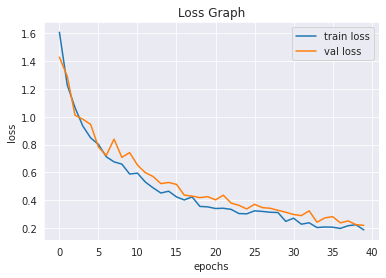

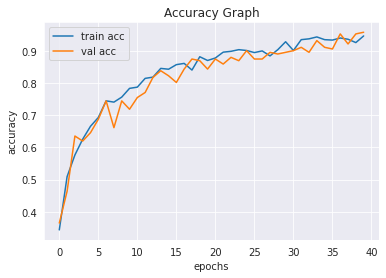

<Figure size 432x288 with 0 Axes>

In [38]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs') 
plt.ylabel('loss')
plt.title('Loss Graph')  
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epochs') 
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [39]:
model.load_weights("weights.h5")
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[39  0  0  1  0]
 [ 0 40  0  0  0]
 [ 0  1 36  2  1]
 [ 0  0  1 39  0]
 [ 0  1  0  1 39]]
Classification Report
              precision    recall  f1-score   support

        jute       1.00      0.97      0.99        40
       maize       0.95      1.00      0.98        40
        rice       0.97      0.90      0.94        40
   sugarcane       0.91      0.97      0.94        40
       wheat       0.97      0.95      0.96        41

    accuracy                           0.96       201
   macro avg       0.96      0.96      0.96       201
weighted avg       0.96      0.96      0.96       201



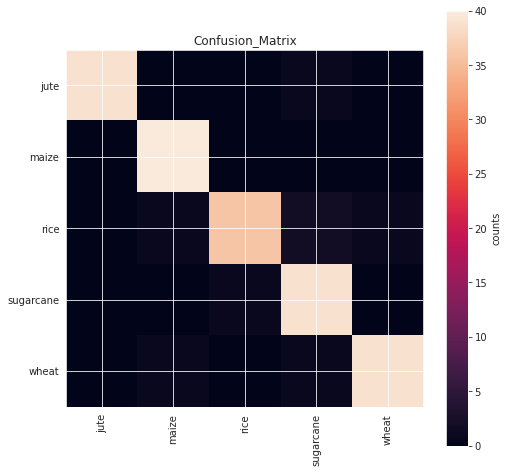

In [40]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation=None)
plt.title('Confusion_Matrix')
plt.colorbar(label="counts")
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

Random Images Predictions

In [41]:
import cv2
import numpy as np

In [42]:
def predict_crop(path,actual,class_labels):
    predict_datagen = ImageDataGenerator(rescale=1./255)
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img = np.array(img).reshape((1, 224, 224, 3))
    Y_pred = model.predict(img)
    y_pred = np.argmax(Y_pred, axis=1)
    if y_pred == actual:
        print('Correct prediction')
    else:
        print("Messed up!!")
    print('Actual class "{0}" and predicted class "{1}"'.format(class_labels[actual],class_labels[int(y_pred)]))



In [43]:
class_labels

{0: 'jute', 1: 'maize', 2: 'rice', 3: 'sugarcane', 4: 'wheat'}

In [46]:
predict_crop('/content/drive/MyDrive/Crop dataset/random_crop_image/wheatcrop01.jpg',4,class_labels)

Correct prediction
Actual class "wheat" and predicted class "wheat"


In [45]:
predict_crop('/content/drive/MyDrive/Crop dataset/random_crop_image/wheat.jpg',4,class_labels)

Messed up!!
Actual class "wheat" and predicted class "rice"


In [50]:
predict_crop('/content/drive/MyDrive/Crop dataset/random_crop_image/sugarcane-farm-in-the-mountain-countryside-of-thailand.jpg',3,class_labels)

Messed up!!
Actual class "sugarcane" and predicted class "jute"


In [51]:
predict_crop('/content/drive/MyDrive/Crop dataset/random_crop_image/jute003.jpg',0,class_labels)

Correct prediction
Actual class "jute" and predicted class "jute"
